In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional,LSTM, Dense, Conv1D,GlobalMaxPooling1D,MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

Epoch 1/10
289/289 [==============================] - 22s 67ms/step - loss: 1.7524 - accuracy: 0.2149 - val_loss: 1.7236 - val_accuracy: 0.2421
Epoch 2/10
289/289 [==============================] - 10s 35ms/step - loss: 1.6418 - accuracy: 0.3056 - val_loss: 1.7299 - val_accuracy: 0.2443
Epoch 3/10
289/289 [==============================] - 8s 28ms/step - loss: 1.3786 - accuracy: 0.4697 - val_loss: 1.8708 - val_accuracy: 0.2399
Epoch 4/10
289/289 [==============================] - 9s 31ms/step - loss: 1.0379 - accuracy: 0.6184 - val_loss: 2.1188 - val_accuracy: 0.2334
Epoch 5/10
289/289 [==============================] - 8s 29ms/step - loss: 0.7666 - accuracy: 0.7288 - val_loss: 2.3819 - val_accuracy: 0.2265
Epoch 6/10
289/289 [==============================] - 9s 30ms/step - loss: 0.5767 - accuracy: 0.8043 - val_loss: 2.8439 - val_accuracy: 0.2347
Epoch 7/10
289/289 [==============================] - 9s 30ms/step - loss: 0.4443 - accuracy: 0.8461 - val_loss: 2.9447 - val_accuracy: 0.22

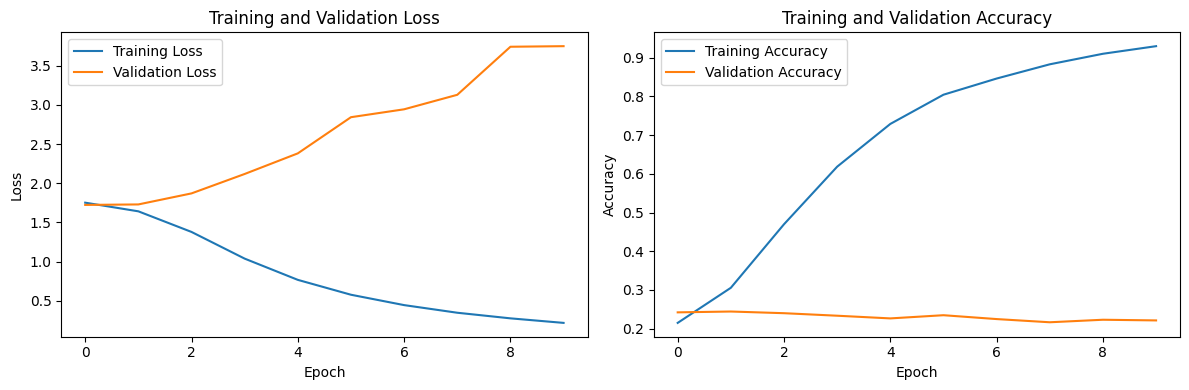

40/40 [==============================] - 1s 17ms/step - loss: 3.7156 - accuracy: 0.2092
Test Loss: 3.7156, Test Accuracy: 0.2092


In [ ]:
strategy = tf.distribute.MirroredStrategy()

# Load data
train_data = pd.read_csv('data/train.tsv', sep='\t', header=None, names=['ID', 'Label', 'Statement', 'Subject', 'Speaker', 'Speaker_job', 'State', 'Party', 'Barely_true', 'False', 'Half_true', 'Mostly_true', 'Pants_on_fire', 'Venue'])
test_data = pd.read_csv('data/test.tsv', sep='\t', header=None, names=['ID', 'Label', 'Statement', 'Subject', 'Speaker', 'Speaker_job', 'State', 'Party', 'Barely_true', 'False', 'Half_true', 'Mostly_true', 'Pants_on_fire', 'Venue'])
valid_data = pd.read_csv('data/valid.tsv', sep='\t', header=None, names=['ID', 'Label', 'Statement', 'Subject', 'Speaker', 'Speaker_job', 'State', 'Party', 'Barely_true', 'False', 'Half_true', 'Mostly_true', 'Pants_on_fire', 'Venue'])

# Concatenate train and validation data for training
train_data = pd.concat([train_data, valid_data])

# Preprocess text data
texts = train_data['Statement'].values
labels = train_data['Label'].values

# Convert labels to numerical format
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
vocab_size = len(tokenizer.word_index) + 1

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(texts)
max_sequence_length = max(len(seq) for seq in sequences)

# Pad sequences for uniform length
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Build the model inside the strategy scope
with strategy.scope():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_sequence_length))
    model.add(LSTM(100, dropout=0.2))  # Adjust the dropout rate as needed
    model.add(Dropout(0.5))  # Add dropout after LSTM
    model.add(Dense(6, activation='softmax'))
    custom_optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=custom_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model and store the history
history = model.fit(padded_sequences, labels, epochs=10, validation_split=0.2)

# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Evaluate the model on the test set
test_texts = test_data['Statement'].values
test_labels = label_encoder.transform(test_data['Label'].values)

# Tokenize and pad test sequences
test_sequences = tokenizer.texts_to_sequences(test_texts)
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(padded_test_sequences, test_labels)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')


Epoch 1/10
289/289 [==============================] - 28s 86ms/step - loss: 1.7532 - accuracy: 0.2109 - val_loss: 1.7385 - val_accuracy: 0.2547
Epoch 2/10
289/289 [==============================] - 15s 53ms/step - loss: 1.6444 - accuracy: 0.2963 - val_loss: 1.7265 - val_accuracy: 0.2377
Epoch 3/10
289/289 [==============================] - 14s 48ms/step - loss: 1.3739 - accuracy: 0.4591 - val_loss: 1.8668 - val_accuracy: 0.2360
Epoch 4/10
289/289 [==============================] - 14s 48ms/step - loss: 1.0125 - accuracy: 0.6287 - val_loss: 2.1570 - val_accuracy: 0.2308
Epoch 5/10
289/289 [==============================] - 14s 48ms/step - loss: 0.7266 - accuracy: 0.7481 - val_loss: 2.3958 - val_accuracy: 0.2265
Epoch 6/10
289/289 [==============================] - 14s 48ms/step - loss: 0.5348 - accuracy: 0.8192 - val_loss: 2.8324 - val_accuracy: 0.2343
Epoch 7/10
289/289 [==============================] - 14s 48ms/step - loss: 0.4118 - accuracy: 0.8597 - val_loss: 3.0437 - val_accuracy:

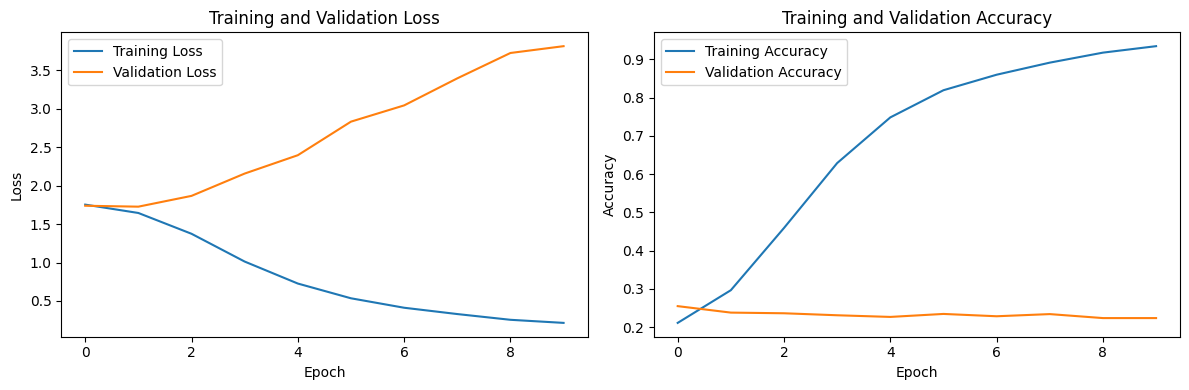

40/40 [==============================] - 1s 20ms/step - loss: 3.7248 - accuracy: 0.2297
Test Loss: 3.7248, Test Accuracy: 0.2297


In [ ]:
# Build the model inside the strategy scope
with strategy.scope():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_sequence_length))
    model.add(Bidirectional(LSTM(100, dropout=0.2)))  # BiLSTM layer
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='softmax'))
    custom_optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=custom_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model and store the history
history3 = model.fit(padded_sequences, labels, epochs=10, validation_split=0.2)

# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Evaluate the model on the test set
test_texts = test_data['Statement'].values
test_labels = label_encoder.transform(test_data['Label'].values)

# Tokenize and pad test sequences
test_sequences = tokenizer.texts_to_sequences(test_texts)
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(padded_test_sequences, test_labels)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')


Epoch 1/10
289/289 [==============================] - 20s 50ms/step - loss: 1.7597 - accuracy: 0.2031 - val_loss: 1.7412 - val_accuracy: 0.2542
Epoch 2/10
289/289 [==============================] - 6s 20ms/step - loss: 1.7154 - accuracy: 0.2421 - val_loss: 1.7353 - val_accuracy: 0.2482
Epoch 3/10
289/289 [==============================] - 5s 16ms/step - loss: 1.6021 - accuracy: 0.3099 - val_loss: 1.7717 - val_accuracy: 0.2351
Epoch 4/10
289/289 [==============================] - 4s 13ms/step - loss: 1.2780 - accuracy: 0.4777 - val_loss: 1.9661 - val_accuracy: 0.2265
Epoch 5/10
289/289 [==============================] - 3s 11ms/step - loss: 0.8784 - accuracy: 0.6721 - val_loss: 2.3761 - val_accuracy: 0.2191
Epoch 6/10
289/289 [==============================] - 4s 14ms/step - loss: 0.5585 - accuracy: 0.8034 - val_loss: 3.0915 - val_accuracy: 0.2139
Epoch 7/10
289/289 [==============================] - 4s 15ms/step - loss: 0.3851 - accuracy: 0.8719 - val_loss: 3.7754 - val_accuracy: 0.221

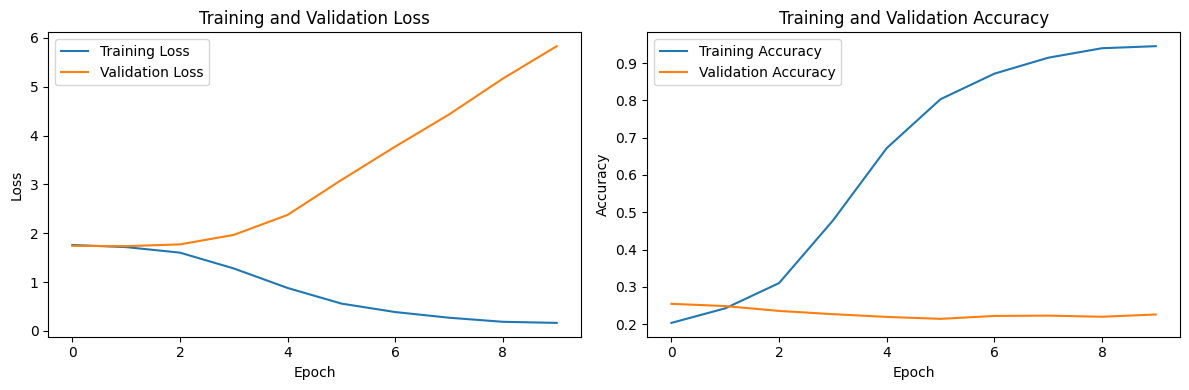

40/40 [==============================] - 0s 6ms/step - loss: 5.8383 - accuracy: 0.2265
Test Loss: 5.8383, Test Accuracy: 0.2265


In [ ]:
# Build the model inside the strategy scope
with strategy.scope():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_sequence_length))
    model.add(Conv1D(128, 5, activation='relu'))  # 1D Convolutional layer
    model.add(MaxPooling1D(5))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='softmax'))
    custom_optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=custom_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model and store the history
history5 = model.fit(padded_sequences, labels, epochs=10, validation_split=0.2)

# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history5.history['loss'], label='Training Loss')
plt.plot(history5.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history5.history['accuracy'], label='Training Accuracy')
plt.plot(history5.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Evaluate the model on the test set
test_texts = test_data['Statement'].values
test_labels = label_encoder.transform(test_data['Label'].values)

# Tokenize and pad test sequences
test_sequences = tokenizer.texts_to_sequences(test_texts)
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(padded_test_sequences, test_labels)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')


Epoch 1/10
289/289 [==============================] - 21s 62ms/step - loss: 0.6697 - accuracy: 0.5881 - val_loss: 0.6503 - val_accuracy: 0.6226
Epoch 2/10
289/289 [==============================] - 9s 32ms/step - loss: 0.5590 - accuracy: 0.7173 - val_loss: 0.7019 - val_accuracy: 0.5991
Epoch 3/10
289/289 [==============================] - 9s 30ms/step - loss: 0.3910 - accuracy: 0.8273 - val_loss: 0.8477 - val_accuracy: 0.5987
Epoch 4/10
289/289 [==============================] - 8s 27ms/step - loss: 0.2583 - accuracy: 0.8941 - val_loss: 1.0488 - val_accuracy: 0.5614
Epoch 5/10
289/289 [==============================] - 8s 29ms/step - loss: 0.1682 - accuracy: 0.9313 - val_loss: 1.3138 - val_accuracy: 0.5787
Epoch 6/10
289/289 [==============================] - 9s 29ms/step - loss: 0.1067 - accuracy: 0.9588 - val_loss: 1.6721 - val_accuracy: 0.5779
Epoch 7/10
289/289 [==============================] - 8s 27ms/step - loss: 0.0731 - accuracy: 0.9723 - val_loss: 1.8415 - val_accuracy: 0.564

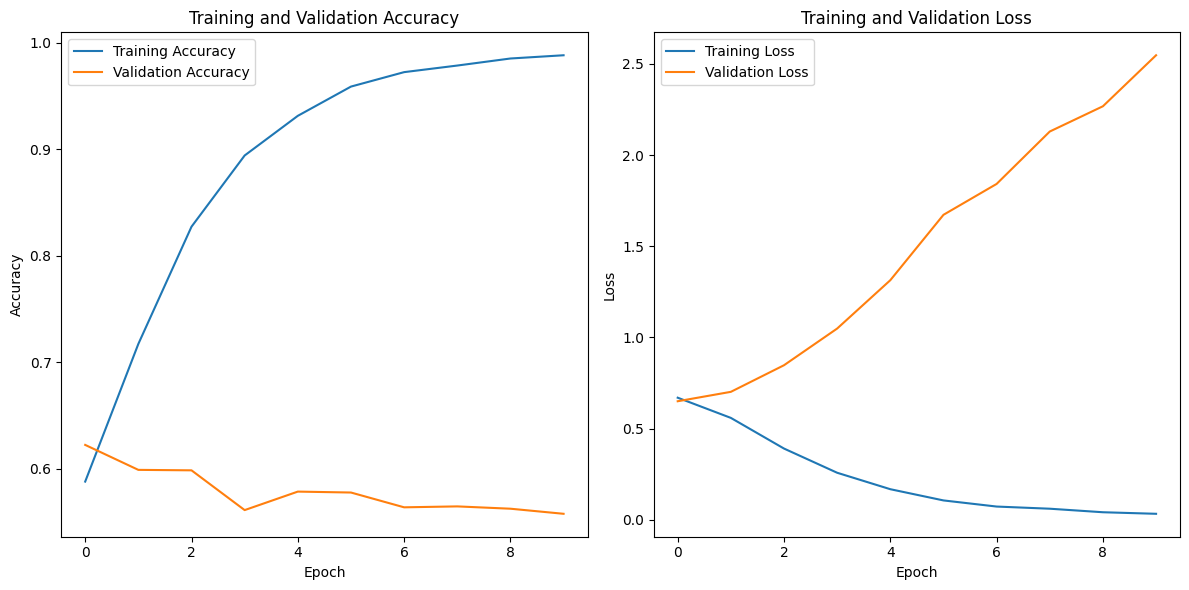

40/40 [==============================] - 0s 10ms/step - loss: 2.6146 - accuracy: 0.5493
Test Loss: 2.6146, Test Accuracy: 0.5493


In [ ]:
# Load data
train_data = pd.read_csv('data/train.tsv', sep='\t', header=None, names=['ID', 'Label', 'Statement', 'Subject', 'Speaker', 'Speaker_job', 'State', 'Party', 'Barely_true', 'False', 'Half_true', 'Mostly_true', 'Pants_on_fire', 'Venue'])
test_data = pd.read_csv('data/test.tsv', sep='\t', header=None, names=['ID', 'Label', 'Statement', 'Subject', 'Speaker', 'Speaker_job', 'State', 'Party', 'Barely_true', 'False', 'Half_true', 'Mostly_true', 'Pants_on_fire', 'Venue'])
valid_data = pd.read_csv('data/valid.tsv', sep='\t', header=None, names=['ID', 'Label', 'Statement', 'Subject', 'Speaker', 'Speaker_job', 'State', 'Party', 'Barely_true', 'False', 'Half_true', 'Mostly_true', 'Pants_on_fire', 'Venue'])

# Concatenate train and validation data for training
train_data = pd.concat([train_data, valid_data])

# Preprocess text data
texts = train_data['Statement'].values
labels = train_data['Label'].values

# Define two-way classification dictionary
label_to_number_2_way_classification = {
    'pants-fire': 0,
    'false': 0,
    'barely-true': 0,
    'half-true': 1,
    'mostly-true': 1,
    'true': 1
}

# Convert labels to numerical format
labels_binary = [label_to_number_2_way_classification[label] for label in labels]

# Split the data into training and validation sets
train_texts, valid_texts, train_labels_binary, valid_labels_binary = train_test_split(texts, labels_binary, test_size=0.2, random_state=42)

# Convert label lists to NumPy arrays
labels_binary = np.array(labels_binary)
train_labels_binary = np.array(train_labels_binary)
valid_labels_binary = np.array(valid_labels_binary)

# Tokenize and pad training sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
padded_train_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length)

# Tokenize and pad validation sequences
valid_sequences = tokenizer.texts_to_sequences(valid_texts)
padded_valid_sequences = pad_sequences(valid_sequences, maxlen=max_sequence_length)

# Build the model inside the strategy scope
with strategy.scope():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_sequence_length))
    model.add(LSTM(100))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with explicit validation data
history2 = model.fit(padded_train_sequences, train_labels_binary, epochs=10, validation_data=(padded_valid_sequences, valid_labels_binary))


# Evaluate the model on the test set
test_texts = test_data['Statement'].values
test_labels_binary = [label_to_number_2_way_classification[label] for label in test_data['Label'].values]

# Tokenize and pad test sequences
test_sequences = tokenizer.texts_to_sequences(test_texts)
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length)

# Convert test labels to NumPy array
test_labels_binary = np.array(test_labels_binary)


# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on the test set
loss, accuracy = model.evaluate(padded_test_sequences, test_labels_binary)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')




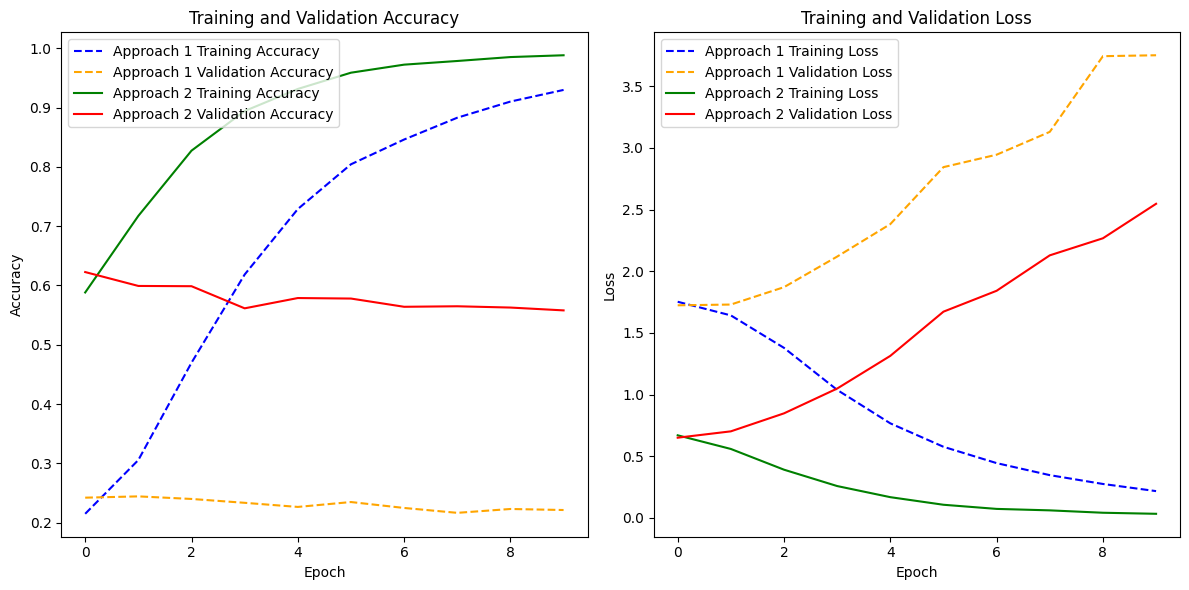

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

# Plot Approach 1 accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Approach 1 Training Accuracy', linestyle='--', color='blue')
plt.plot(history.history['val_accuracy'], label='Approach 1 Validation Accuracy', linestyle='--', color='orange')

# Plot Approach 2 accuracy
plt.plot(history2.history['accuracy'], label='Approach 2 Training Accuracy', linestyle='-', color='green')
plt.plot(history2.history['val_accuracy'], label='Approach 2 Validation Accuracy', linestyle='-', color='red')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Approach 1 Training Loss', linestyle='--', color='blue')
plt.plot(history.history['val_loss'], label='Approach 1 Validation Loss', linestyle='--', color='orange')

plt.plot(history2.history['loss'], label='Approach 2 Training Loss', linestyle='-', color='green')
plt.plot(history2.history['val_loss'], label='Approach 2 Validation Loss', linestyle='-', color='red')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/10
289/289 [==============================] - 27s 81ms/step - loss: 0.6689 - accuracy: 0.5882 - val_loss: 0.6515 - val_accuracy: 0.6243
Epoch 2/10
289/289 [==============================] - 15s 52ms/step - loss: 0.5849 - accuracy: 0.6999 - val_loss: 0.6721 - val_accuracy: 0.6156
Epoch 3/10
289/289 [==============================] - 15s 53ms/step - loss: 0.4330 - accuracy: 0.8004 - val_loss: 0.7473 - val_accuracy: 0.5892
Epoch 4/10
289/289 [==============================] - 14s 47ms/step - loss: 0.2952 - accuracy: 0.8762 - val_loss: 0.9197 - val_accuracy: 0.5892
Epoch 5/10
289/289 [==============================] - 13s 45ms/step - loss: 0.2038 - accuracy: 0.9150 - val_loss: 1.2607 - val_accuracy: 0.5896
Epoch 6/10
289/289 [==============================] - 13s 45ms/step - loss: 0.1381 - accuracy: 0.9459 - val_loss: 1.4450 - val_accuracy: 0.5575
Epoch 7/10
289/289 [==============================] - 13s 45ms/step - loss: 0.1032 - accuracy: 0.9612 - val_loss: 1.5840 - val_accuracy:

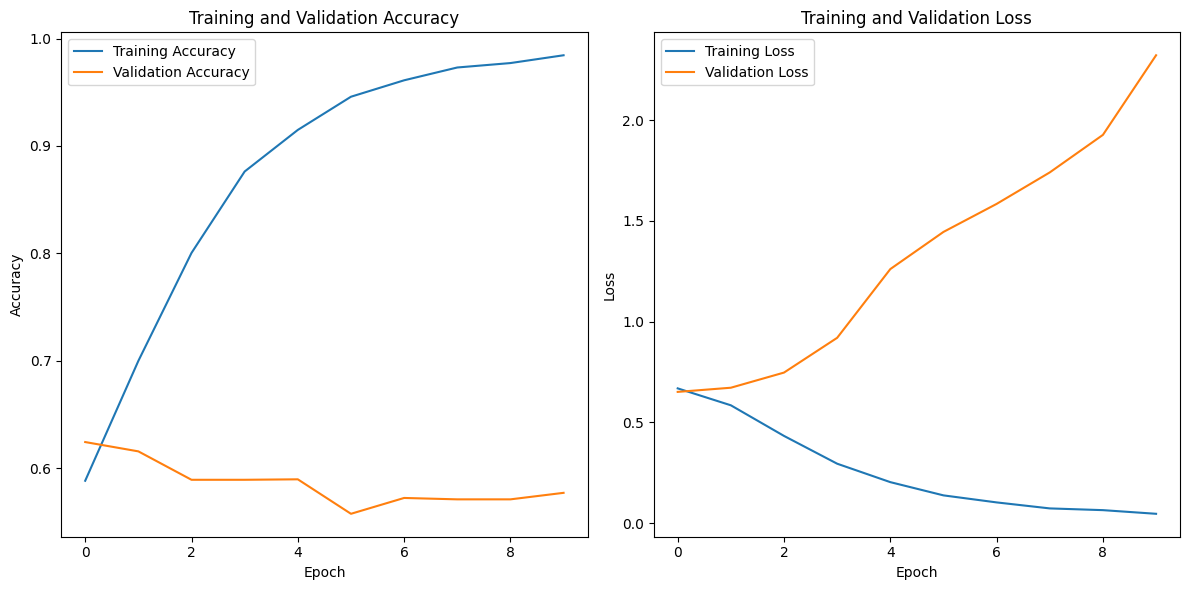

40/40 [==============================] - 1s 23ms/step - loss: 2.3454 - accuracy: 0.5675
Test Loss: 2.3454, Test Accuracy: 0.5675


In [ ]:

# Build the model inside the strategy scope
with strategy.scope():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_sequence_length))
    model.add(Bidirectional(LSTM(100, dropout=0.2)))  # BiLSTM layer
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with explicit validation data
history4 = model.fit(padded_train_sequences, train_labels_binary, epochs=10, validation_data=(padded_valid_sequences, valid_labels_binary))


# Evaluate the model on the test set
test_texts = test_data['Statement'].values
test_labels_binary = [label_to_number_2_way_classification[label] for label in test_data['Label'].values]

# Tokenize and pad test sequences
test_sequences = tokenizer.texts_to_sequences(test_texts)
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length)

# Convert test labels to NumPy array
test_labels_binary = np.array(test_labels_binary)



# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history4.history['accuracy'], label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on the test set
loss, accuracy = model.evaluate(padded_test_sequences, test_labels_binary)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')




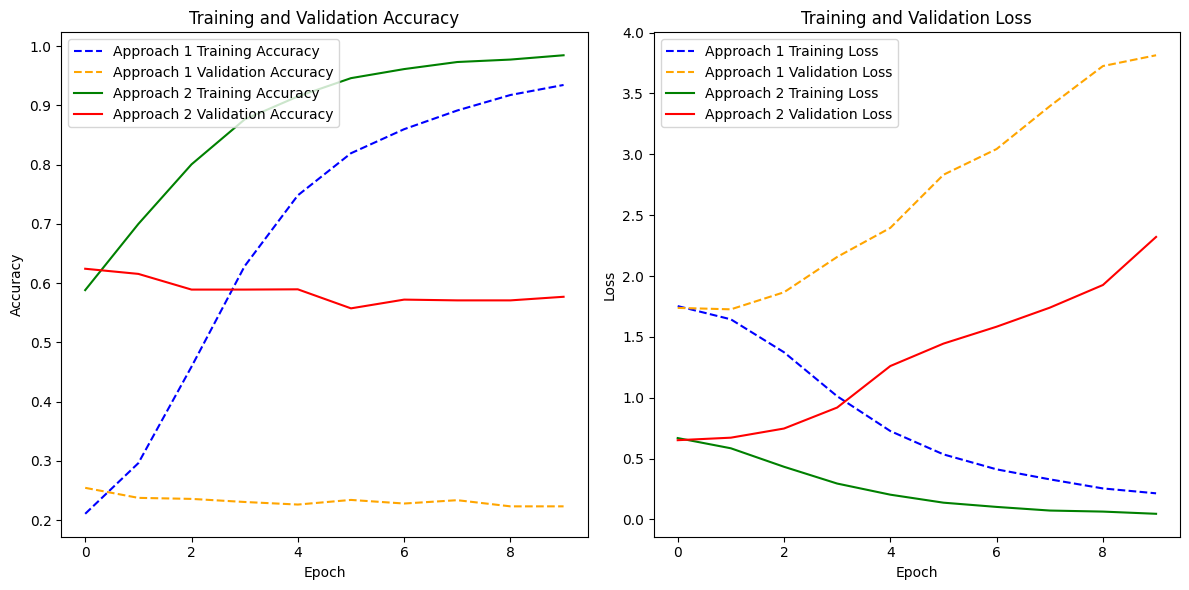

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

# Plot Approach 1 accuracy
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], label='Approach 1 Training Accuracy', linestyle='--', color='blue')
plt.plot(history3.history['val_accuracy'], label='Approach 1 Validation Accuracy', linestyle='--', color='orange')

# Plot Approach 2 accuracy
plt.plot(history4.history['accuracy'], label='Approach 2 Training Accuracy', linestyle='-', color='green')
plt.plot(history4.history['val_accuracy'], label='Approach 2 Validation Accuracy', linestyle='-', color='red')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], label='Approach 1 Training Loss', linestyle='--', color='blue')
plt.plot(history3.history['val_loss'], label='Approach 1 Validation Loss', linestyle='--', color='orange')

plt.plot(history4.history['loss'], label='Approach 2 Training Loss', linestyle='-', color='green')
plt.plot(history4.history['val_loss'], label='Approach 2 Validation Loss', linestyle='-', color='red')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/10
289/289 [==============================] - 14s 44ms/step - loss: 0.6759 - accuracy: 0.5739 - val_loss: 0.6499 - val_accuracy: 0.6312
Epoch 2/10
289/289 [==============================] - 5s 16ms/step - loss: 0.5708 - accuracy: 0.7124 - val_loss: 0.6716 - val_accuracy: 0.6178
Epoch 3/10
289/289 [==============================] - 4s 12ms/step - loss: 0.2998 - accuracy: 0.8894 - val_loss: 0.8674 - val_accuracy: 0.6022
Epoch 4/10
289/289 [==============================] - 4s 15ms/step - loss: 0.0814 - accuracy: 0.9771 - val_loss: 1.1644 - val_accuracy: 0.5883
Epoch 5/10
289/289 [==============================] - 4s 13ms/step - loss: 0.0206 - accuracy: 0.9960 - val_loss: 1.3727 - val_accuracy: 0.5848
Epoch 6/10
289/289 [==============================] - 3s 12ms/step - loss: 0.0081 - accuracy: 0.9988 - val_loss: 1.5915 - val_accuracy: 0.5913
Epoch 7/10
289/289 [==============================] - 4s 14ms/step - loss: 0.0059 - accuracy: 0.9993 - val_loss: 1.7341 - val_accuracy: 0.594

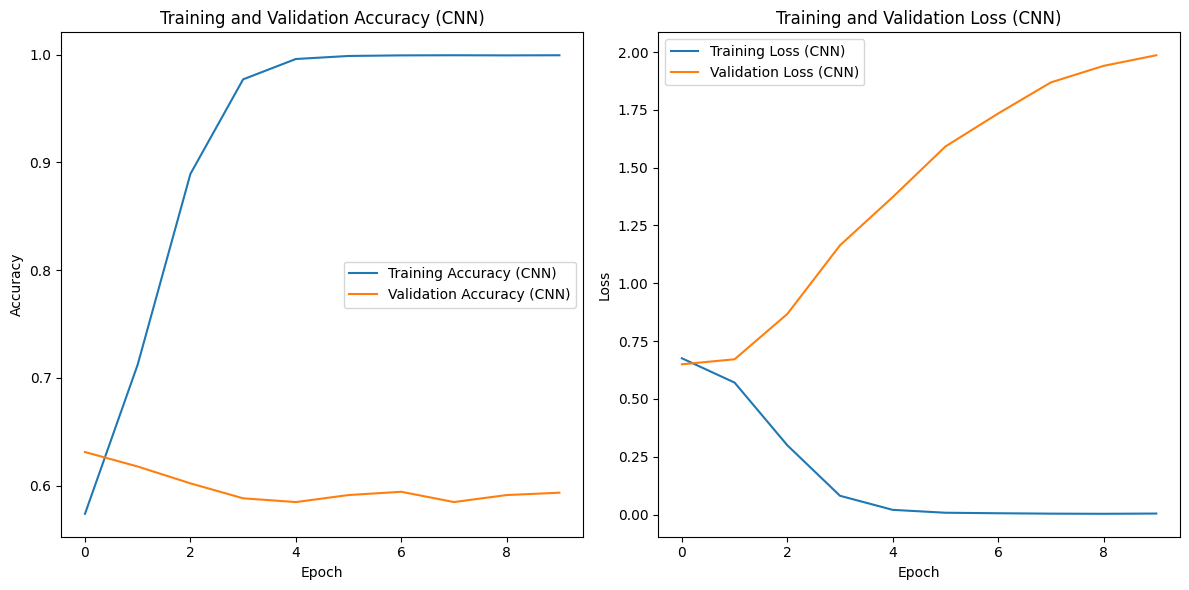

40/40 [==============================] - 0s 5ms/step - loss: 1.9414 - accuracy: 0.6038
Test Loss (CNN): 1.9414, Test Accuracy (CNN): 0.6038


In [ ]:
# Build the model inside the strategy scope
with strategy.scope():
    model_cnn = Sequential()
    model_cnn.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_sequence_length))
    model_cnn.add(Conv1D(128, 5, activation='relu'))
    model_cnn.add(GlobalMaxPooling1D())
    model_cnn.add(Dense(64, activation='relu'))
    model_cnn.add(Dropout(0.5))
    model_cnn.add(Dense(1, activation='sigmoid'))  # Binary classification
    model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with explicit validation data
history6 = model_cnn.fit(padded_train_sequences, train_labels_binary, epochs=10, validation_data=(padded_valid_sequences, valid_labels_binary))

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history6.history['accuracy'], label='Training Accuracy (CNN)')
plt.plot(history6.history['val_accuracy'], label='Validation Accuracy (CNN)')
plt.title('Training and Validation Accuracy (CNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history6.history['loss'], label='Training Loss (CNN)')
plt.plot(history6.history['val_loss'], label='Validation Loss (CNN)')
plt.title('Training and Validation Loss (CNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the CNN model on the test set
test_sequences = tokenizer.texts_to_sequences(test_data['Statement'].values)
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length)
test_labels_binary = np.array([label_to_number_2_way_classification[label] for label in test_data['Label'].values])

loss_cnn, accuracy_cnn = model_cnn.evaluate(padded_test_sequences, test_labels_binary)
print(f'Test Loss (CNN): {loss_cnn:.4f}, Test Accuracy (CNN): {accuracy_cnn:.4f}')


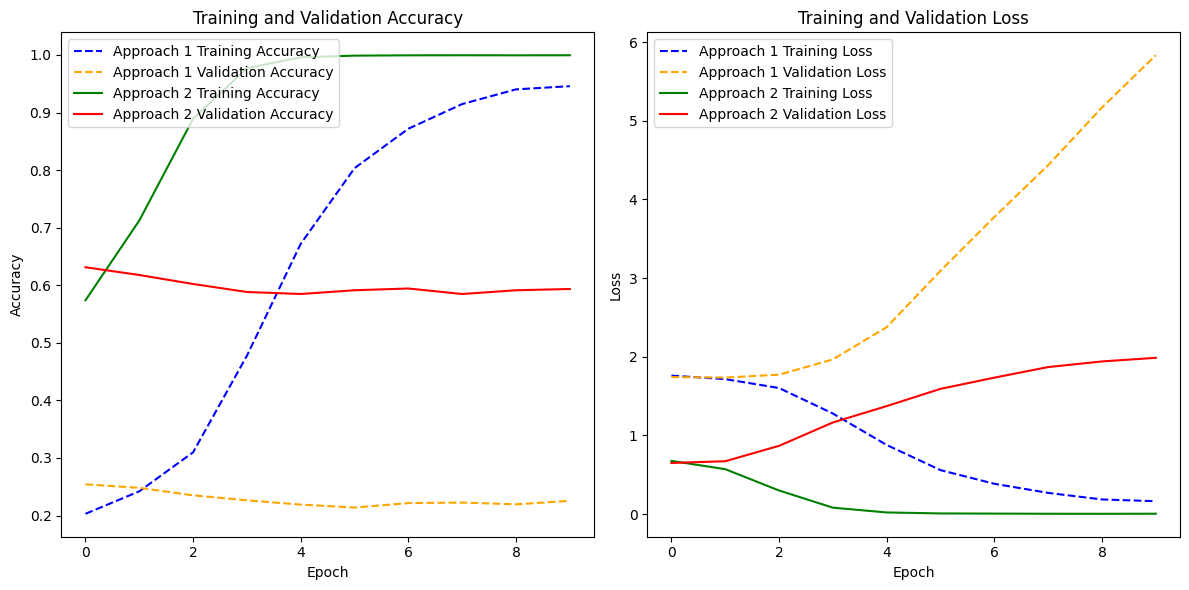

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

# Plot Approach 1 accuracy
plt.subplot(1, 2, 1)
plt.plot(history5.history['accuracy'], label='Approach 1 Training Accuracy', linestyle='--', color='blue')
plt.plot(history5.history['val_accuracy'], label='Approach 1 Validation Accuracy', linestyle='--', color='orange')

# Plot Approach 2 accuracy
plt.plot(history6.history['accuracy'], label='Approach 2 Training Accuracy', linestyle='-', color='green')
plt.plot(history6.history['val_accuracy'], label='Approach 2 Validation Accuracy', linestyle='-', color='red')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history5.history['loss'], label='Approach 1 Training Loss', linestyle='--', color='blue')
plt.plot(history5.history['val_loss'], label='Approach 1 Validation Loss', linestyle='--', color='orange')

plt.plot(history6.history['loss'], label='Approach 2 Training Loss', linestyle='-', color='green')
plt.plot(history6.history['val_loss'], label='Approach 2 Validation Loss', linestyle='-', color='red')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
